In [1]:
import xgboost as xgb
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Loading and Preprocessing the Dataset

In [18]:
# Work in "Training" Mode for fitting the model, and switch to "Submission" for the final work on the full Dataset
mode = "Training"

In [50]:
# Create the dataset
boston = load_boston()
data, target, feature_names = boston.data, boston.target, boston.feature_names

# Join the dataset and the target into one full df
df_full = pd.DataFrame(np.concatenate((data, target.reshape((506,1))), axis=1), columns=[*feature_names, 'target'])

# Generate Training Splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_full.drop('target', axis=1), target)

# Specify to work on a portion of the 
train = True
if mode == "Training":
    df = X_train
    target = y_train
elif mode == "Submission":
    df = df_full
    target = df['target']

# Prepare the Dataset
df['CHAS'] = df['CHAS'].astype('int').astype('category')
df['RAD'] = df['RAD'].astype('int').astype('category')
numeric_cols = [col for col in df.columns if df[col].dtype in ['float64', 'float32', 'int64', 'int32']]

In [51]:
display(df_full.shape, df.shape, X_test.shape)

(506, 14)

(379, 13)

(127, 13)

In [21]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [22]:
display( df.dtypes, df.head(2))

CRIM        float64
ZN          float64
INDUS       float64
CHAS       category
NOX         float64
RM          float64
AGE         float64
DIS         float64
RAD        category
TAX         float64
PTRATIO     float64
B           float64
LSTAT       float64
dtype: object

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
483,2.81838,0.0,18.10,0,0.532,5.762,40.3,4.0983,24,666.0,20.2,392.92,10.42
152,1.12658,0.0,19.58,1,0.871,5.012,88.0,1.6102,5,403.0,14.7,343.28,12.12


### Establish a quick baseline

Before starting off to deploy any kind of feature engineering, we should always first try to get a baseline for the accuracy we can expect from our models

In [25]:
# Train a Linear Model
train_linear_model(train_df=X_train, test_df=X_test, train_target=y_train, test_target=y_test)

The LinearRegression reached an accuracy of:
 Training 0.7573626121798365 	 Validation 0.599959703165688



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
# Train a Ensemble Model
rf_estimator = train_ensemble_model(train_df=X_train, test_df=X_test, train_target=y_train, test_target=y_test, gridCV=True)

Using the default GridCV param_grid for the RandomForestRegressor
The RandomForestRegressor reached an accuracy of:
 Training 0.983386469385309 	 Validation 0.744572591021406

{'bootstrap': True, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 380}


## Inspecting the Feature Importance

Manual inspection of **Numerical Features**:
- Distribution of the variable
- Relationship to the Outcome variable
- Correlation pattern in the strongest correlations in the Dataset


To understand what are the most important features i can:
- Train a DecisionTreeRegressor and plot its feature weights
- Export the decision surf

In [32]:
df.keys()

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

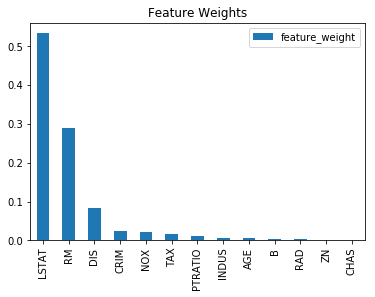

In [41]:
plot_feature_weights(X_train, X_test, y_train, y_test)

## 1. Analyze Numeric Columns

Numerical Features can be complex and hard to work with for Tree based models, as they need to perform many splits to approximate value regression tasks. 
Therefore models can reach a high number of splits on specific features, maxing out the max_depth of the Tree quickly. This would restrict the model from ever completly fitting the training data, and as such lead to high variance which is to be avoided. 

To support Tree based Models in our Ensemble to capture these linear dependencies, we provide a number of binary features, as well as precomputed statistics to the model. 

Process: 
1. We standardize the values in the columns to provide equal weight on all features 
2. We apply statistical interactions between the most relevant Features
3. We bin numerical values to provide groups of datapoints to our classifier
4. We apply an iterative optimization to each binned column 
5. We group the columns into clusters and add additional statistics about the cluster to the instances
 

### 1.1 Standardize Numerical Features

In order to give each feature equal influence within our Algoritms, and ensure we penalize each feature dimension equally we need to standardize the data. 

Then we can inspect the distributions of the features and see if we can get better results by applying numerical transformations on the data

In [42]:
from sklearn.preprocessing import StandardScaler

# Apply scaling to all items (Fit to the training Data, transform training and test data with the weights learned from training data)
norm_scaler = StandardScaler().fit(X_train[numeric_cols])
X_train_scaled = pd.DataFrame(norm_scaler.transform(X_train[numeric_cols]), columns=X_train[numeric_cols].columns)
X_test_scaled = pd.DataFrame(norm_scaler.transform(X_test[numeric_cols]), columns=X_test[numeric_cols].columns)

In [48]:
train_linear_model(X_train_scaled, X_test_scaled, y_train, y_test)

The LinearRegression reached an accuracy of:
 Training 0.7353619304579153 	 Validation 0.6084233657173813



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
scaled_rf_reg = rf_estimator.fit(X_train_scaled, y_train)
scaled_rf_reg.score(X_test_scaled, y_test)

0.7380602305993365

-------------------------
**Result**

Scaling the numerical features seems to hurt the performance of the RandomForest Model

and gave only slight improvements to the linear model

-------------------------

#### 1.2 Applying polynomial features to the Data

We can automatically generate a power series for various degree for each of our input features to try to capture complex non-linear dependencies in the data. This process here implements the following functionalities:

##### Functions
1. **cross_validate_polynomial_features**: Enables a quick look how a given model reacts to various degrees of polynomial features
2. **append_polynomial_features**: Enables to add a the columns up to a specified degree to the Dataframe (when rerunning it automatically cleans the dataset if old generated columns should be present
3. 

In [49]:
from sklearn.preprocessing import PolynomialFeatures

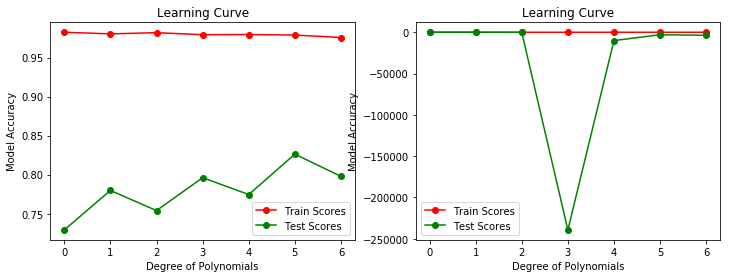

In [50]:
# Cross validate polynomial features
plt.subplots(figsize=(12, 4))
plt.subplot(121)
rf_train, rf_val = cross_validate_polynomial_features(X_train, X_test, y_train, y_test, rng=range(1,8), modelclass="ensemble")
plt.subplot(122)
lm_train, lm_val = cross_validate_polynomial_features(X_train, X_test, y_train, y_test, rng=range(1,8), modelclass="linear")

In [54]:
# Append polynomial features to the dataset
degree = 5

# Lets test both with all features
train_poly, test_poly = append_polynomial_features(X_train, X_test, y_train, y_test, degree=degree)

# And Interaction Parameters only
train_int, test_int = append_polynomial_features(X_train, X_test, y_train, y_test, degree=degree, interaction_only=True)

8568 8555
2380 2367


----------------------------------
#### Validation:

1. All paramaters
2. Interactions only

In [60]:
rf_estimator

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=380, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
# 1. All parameter
%time rf_estimator.fit(train_poly, y_train)
rf_estimator.score(test_poly, y_test)

Wall time: 42.2 s


0.7675553468572895

In [63]:
# 2. Interaction parameters only
%time rf_estimator.fit(train_int, y_train)
rf_estimator.score(test_int, y_test)

Wall time: 9 s


0.8121626650509501

**Result**:
Using only the Feature interacions gave us a whopping 8% increase in validation accuracy at a fraction of the training time

### 1.2 Apply Statistical Interactions between Features

In [ ]:
#TODO: Implement a function to apply a list of statistical features between two given feature columns (Abbility to iteratively test performance gains, and reorder feature importance)

### 1.3 Bin Numerical Features

**Goal of binning:** Besides statistical feature Augmentation, the binning of numeric values into discrete categories is often very helpful to enable the model to pick up on relevant inter group dependencies with the dependent variable.


#### Analyzing the most profitable global setting of bining columns for a given Numeric Dataset

- Cross Validate the global setting for the whole Dataset
- Go and individually optimize each numeric column from the global optimal setting for all categories

Fitting 5th Model
Fitting 10th Model
Fitting 15th Model
Done. Best validation result with 0.8483787836629624 at 13 bins


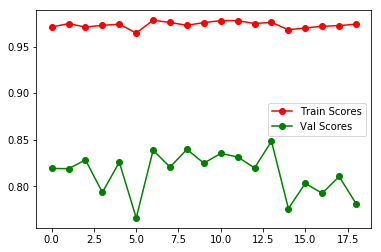

In [26]:
# 1. Cross Validate the best global bin size for all columns
cross_validate_numeric_bin_size(X_train, X_test, y_train, y_test, bin_range=range(1,20), plot=True)

Seems here keeping the category columns helps the model to perform better, but also increases overfitting to the data. Probably because of colinearity between both sets of columns

In [29]:
# Set the model to run on that optimum
bins = 13
train = create_binned_columns(X_train, bins=bins, append=True, drop=False, one_hot_encode=True, cols=numeric_cols)
test = create_binned_columns(X_test, bins=bins, append=True, drop=False, one_hot_encode=True, cols=numeric_cols)

In [30]:
display(train.shape, test.head(3))

(379, 156)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,_LSTAT_bin_3,_LSTAT_bin_4,_LSTAT_bin_5,_LSTAT_bin_6,_LSTAT_bin_7,_LSTAT_bin_8,_LSTAT_bin_9,_LSTAT_bin_10,_LSTAT_bin_11,_LSTAT_bin_12
387,22.59710,0.0,18.10,0.0,0.700,5.000,89.5,1.5184,24.0,666.0,...,0,0,0,0,0,0,0,0,0,1
84,0.05059,0.0,4.49,0.0,0.449,6.389,48.0,4.7794,3.0,247.0,...,0,0,0,0,0,0,0,0,0,0
99,0.06860,0.0,2.89,0.0,0.445,7.416,62.5,3.4952,2.0,276.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
display(test.shape, X_test.head(3))

(127, 156)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
387,22.59710,0.0,18.10,0.0,0.700,5.000,89.5,1.5184,24.0,666.0,20.2,396.9,31.99
84,0.05059,0.0,4.49,0.0,0.449,6.389,48.0,4.7794,3.0,247.0,18.5,396.9,9.62
99,0.06860,0.0,2.89,0.0,0.445,7.416,62.5,3.4952,2.0,276.0,18.0,396.9,6.19


#### Testing impact of applying binning

In [36]:
X_train.shape

(379, 13)

In [34]:
rf_estimator.fit(X_train, y_train)
rf_estimator.score(X_test, y_test)

0.824551590556613

In [37]:
train.shape

(379, 156)

In [35]:
rf_estimator.fit(train, y_train)
rf_estimator.score(test, y_test)

0.8213135355904735

In [39]:
train_ensemble_model(train, test, y_train, y_test, param_grid=param_grid)

The RandomForestRegressor reached an accuracy of:
 Training 0.9769319381287089 	 Validation 0.8272638677686206

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 175}


----------------
**Result**:
    
    Global Binning did not seem to have any performance impact whatsoever on this dataset
    
  -----------------

#### Optimizing individual Column binning settings

Now that we found an optimal setting for a global binning rate for all columns. Let's work from this current optimum and see if we can adjust the most important numeric features to perform better with an individual binning rate.

The process is pretty simple:
- Starting from a global optimimum setting over all numeric columns we go and iteratively optimze each columns binning factor
- For each column we remove the previous encoding columns, and train a RandomForestRegressor on new columns with a given number of 'i' bins
- We then take the best setting, apply it to the original dataframe and proceed to the next column to repeat the process. 
- We can run this process multiple times with the general model, and then finalize it with an appropriately tuned capable final Model

In [42]:
# This function allows to automatically optimize the binning settings for each of the columns to itertively reach ever better fits on the binning numbers
train, test = optimize_column_binning(train, test, y_train, y_test, numeric_cols, bin_range=range(1, 30, 5), optimize_df=True, rounds=0)

Finished optimization for Column: 'CRIM' :: {'best_score': 0.8271871064366682, 'num_bins': 3}
Finished optimization for Column: 'ZN' :: {'best_score': 0.8364896816086321, 'num_bins': 3}
Finished optimization for Column: 'INDUS' :: {'best_score': 0.8637336067145001, 'num_bins': 2}
Finished optimization for Column: 'NOX' :: {'best_score': 0.858189928407439, 'num_bins': 2}
Finished optimization for Column: 'RM' :: {'best_score': 0.8523228220848095, 'num_bins': 0}
Finished optimization for Column: 'AGE' :: {'best_score': 0.8352366312915709, 'num_bins': 3}
Finished optimization for Column: 'DIS' :: {'best_score': 0.8416417891355458, 'num_bins': 3}
Finished optimization for Column: 'TAX' :: {'best_score': 0.8422533906951453, 'num_bins': 3}
Finished optimization for Column: 'PTRATIO' :: {'best_score': 0.8335138786628469, 'num_bins': 1}
Finished optimization for Column: 'B' :: {'best_score': 0.8456169451866616, 'num_bins': 2}
Finished optimization for Column: 'LSTAT' :: {'best_score': 0.847386

In [43]:
# Validation
train_ensemble_model(train, test, y_train, y_test, param_grid=param_grid, n_jobs=-1)

The RandomForestRegressor reached an accuracy of:
 Training 0.97774850630656 	 Validation 0.8247380643385379

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 175}


------------------------------
**Result**:

    Again no improvement from optimizing binning at a local column level

------------------------------

## 2. Group the Data

Apply Clustering Algorithms to find patterns in the now existing data that can give another edge

Summary:
- Train a NearestNeighbors Model to find clusters of variable distance
- Generate min, max, median, std statistics on the clusters
- Append the Data to each training and test instance

Validation:
- Train XGBoost model on the completed Dataset to see increase in model performance

In [52]:
# This groups the data and adds columns for group statistics
train_grouped = add_aggregate_stats_by_distance(X_train, 6, stats=['mean', 'median', 'std', 'min', 'max'])
test_grouped = add_aggregate_stats_by_distance(X_test, 6, stats=['mean','median', 'std', 'min', 'max'])

In [53]:
display(
    train_grouped.shape,
    test_grouped.shape,
    train_grouped.head()
)

(379, 69)

(127, 69)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,kn_group_ZN_std,kn_group_INDUS_std,kn_group_NOX_std,kn_group_RM_std,kn_group_AGE_std,kn_group_DIS_std,kn_group_TAX_std,kn_group_PTRATIO_std,kn_group_B_std,kn_group_LSTAT_std
0,0.06162,0.0,4.39,0,0.442,5.898,52.3,8.0136,3,352.0,...,0.00000,8.548374,0.229531,0.343455,32.269645,3.392419,92.218942,2.858321,120.574649,4.981579
1,0.03738,0.0,5.19,0,0.515,6.310,38.5,6.4584,5,224.0,...,0.00000,8.548374,0.229531,0.343455,32.269645,3.392419,92.218942,2.858321,120.574649,4.981579
2,2.15505,0.0,19.58,0,0.871,5.628,100.0,1.5166,5,403.0,...,0.00000,8.548374,0.229531,0.343455,32.269645,3.392419,92.218942,2.858321,120.574649,4.981579
3,0.05083,0.0,5.19,0,0.515,6.316,38.1,6.4584,5,224.0,...,19.02795,6.375624,0.102716,0.627642,24.349228,1.620862,179.269852,1.706782,132.890718,7.460520
4,0.03551,25.0,4.86,0,0.426,6.167,46.7,5.4007,4,281.0,...,19.02795,6.375624,0.102716,0.627642,24.349228,1.620862,179.269852,1.706782,132.890718,7.460520


In [55]:
# Validation
train_ensemble_model(train_grouped, test_grouped, y_train, y_test, n_jobs=-1, gridCV=True)

Using the default GridCV param_grid for the RandomForestRegressor
The RandomForestRegressor reached an accuracy of:
 Training 0.41752339281223644 	 Validation -0.10873187236780411

{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 450}


In [61]:
from xgboost import XGBRegressor
estimator = XGBRegressor().fit(train_grouped.values, y_train)
estimator.score(test_grouped.values, y_test)

-0.22531458501963142

In [165]:
test_scores

{0: {'n_neighbors': 1, 'score': 0.893342844060144},
 1: {'n_neighbors': 4, 'score': 0.8868369050860956},
 2: {'n_neighbors': 7, 'score': 0.8957834883876846},
 3: {'n_neighbors': 10, 'score': 0.8909549775562737},
 4: {'n_neighbors': 13, 'score': 0.8945065377813315},
 5: {'n_neighbors': 16, 'score': 0.8882331791121109},
 6: {'n_neighbors': 19, 'score': 0.8888720448175317},
 7: {'n_neighbors': 22, 'score': 0.8905174001913502},
 8: {'n_neighbors': 25, 'score': 0.8944023420141961},
 9: {'n_neighbors': 28, 'score': 0.8891623847924207}}

In [171]:
X_train.drop('kn_group', axis=1, inplace=True)
X_test.drop('kn_group', axis=1, inplace=True)

Best validation result : 0.894 with a n_neighbors: 15


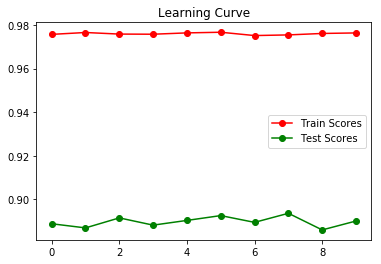

In [181]:
cross_validate_cluster_groups(X_train, X_test, y_train, y_test, cluster_range=range(1, 20, 2), plot=True)

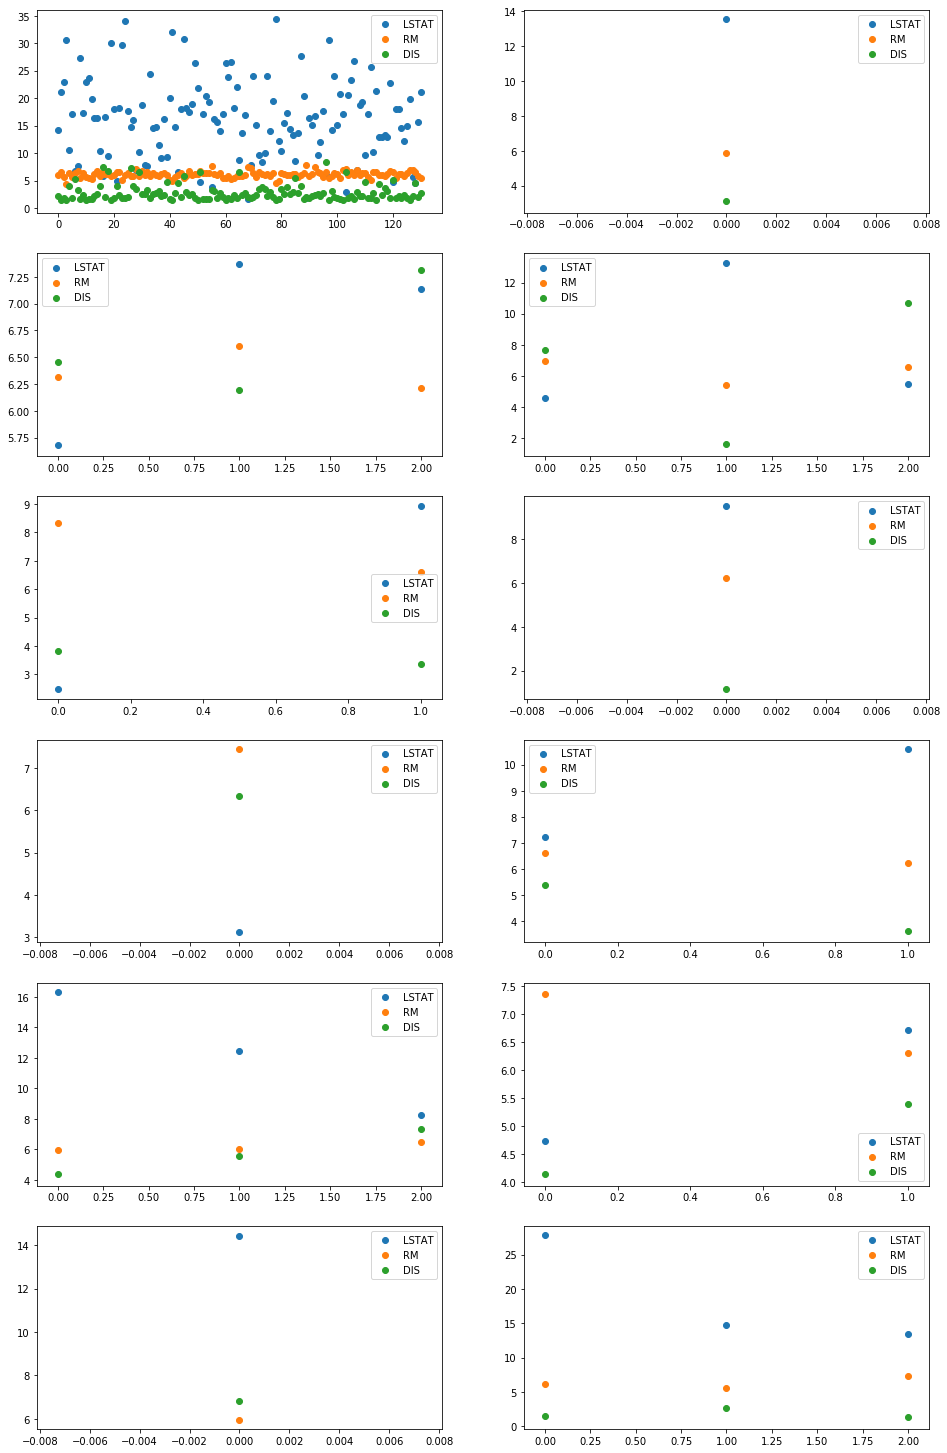

In [107]:
plt.subplots(figsize=(16,44))
idx=0
for i in range(20):
    df = train_grouped[train_grouped['kn_group']== i]
    if df.shape[0] > 0:
        idx += 1
        plt.subplot(10, 2, idx)
        for col in ['LSTAT','RM', 'DIS']:
            plt.scatter(range(df.shape[0]), df[col], label="{}".format(col))
            plt.legend()

## Analyze and Optimize Statistical Features for numeric Columns

After we have introduced an optimized set of binned numeric features to get a better grasp on group related dependencies in the Dataset, we are now off to analyze the statistical structure of the numeric columns. 

- Ensure the Data is free from outliers and imputed values
- Optimize the scaling of the columns
- Introduce interaction statistics to explicitly extract more information from highly important target correlations

Goal here is to enable a quick pipeline of EDA and automatic optimization steps to create the most important features. 

To finalize the process, we will apply Regularization and Dimensionality Reduction as needed to reduce the impact of our Feature Generation on Model Training set fit

In [88]:
# 2. Check the statistics
std = [df[col].std() for col in numeric_cols]
mean = [df[col].mean() for ]

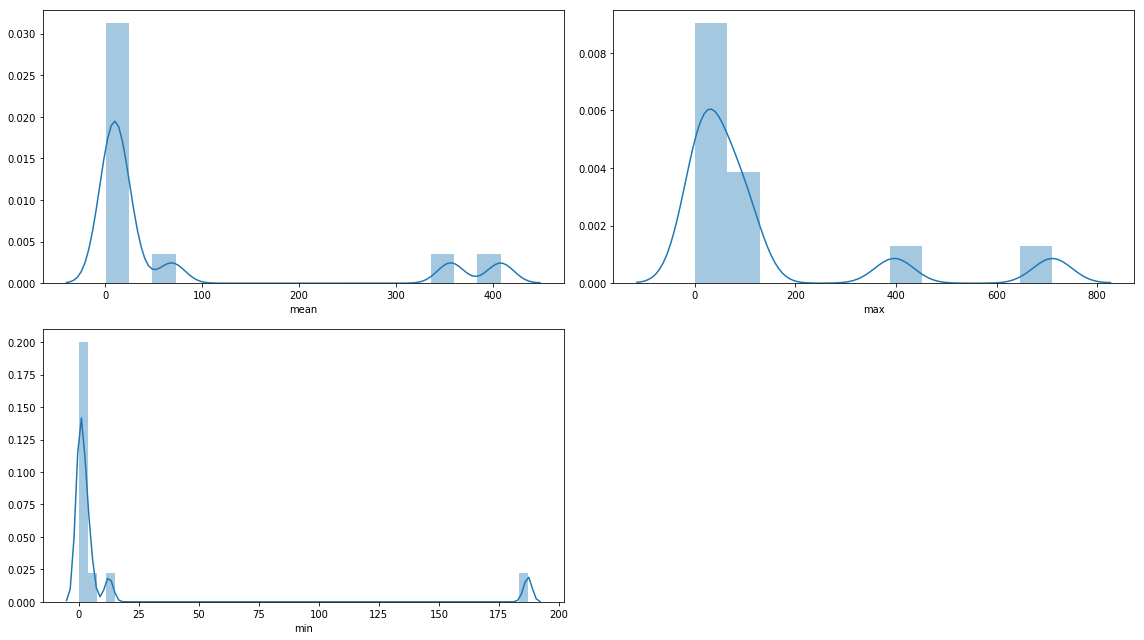

In [106]:
df_desc = df[numeric_cols].describe()

plt.subplots(figsize=(16,9))
plt.subplot(221)
means = df_desc.loc['mean']
sns.distplot(means)

plt.subplot(222)
max = df_desc.loc['max']
sns.distplot(max)

plt.subplot(223)
min = df_desc.loc['min']
sns.distplot(min)

plt.tight_layout()


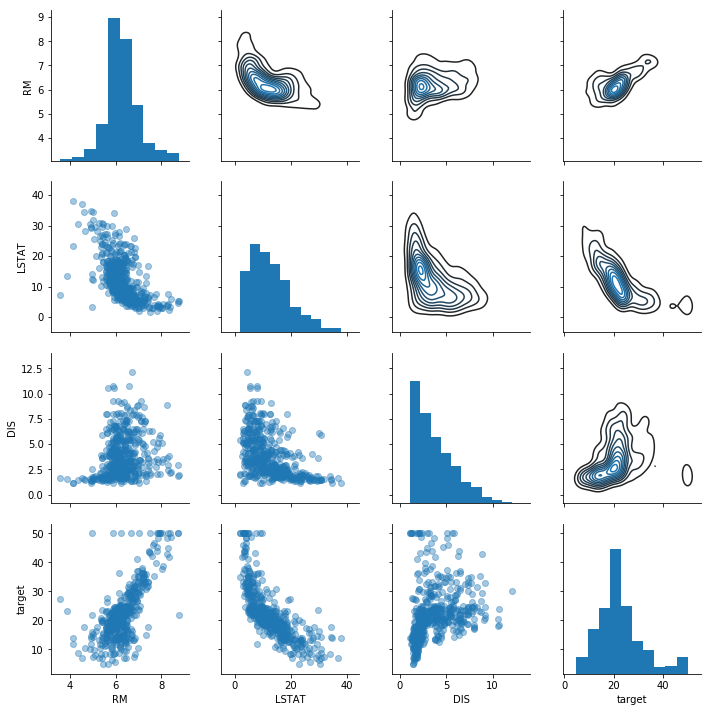

In [130]:
# 2. Plot interactions between the most important Features
g = sns.PairGrid(df[['RM', 'LSTAT', 'DIS', 'target']])
g.map_diag(plt.hist)
g.map_lower(plt.scatter, alpha=0.4)
g.map_upper(sns.kdeplot, legend=False)

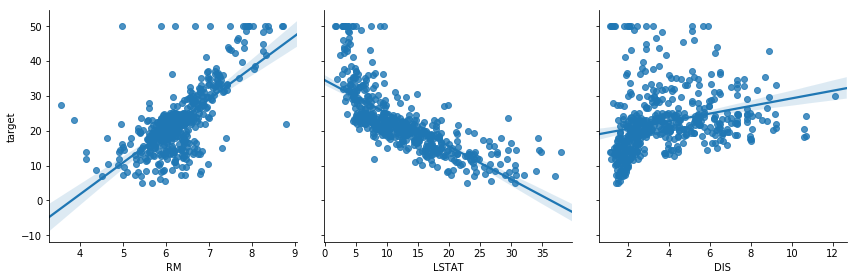

In [153]:
g = sns.PairGrid(df, y_vars='target', x_vars=['RM', 'LSTAT', 'DIS'], height=4)
g.map(sns.regplot)


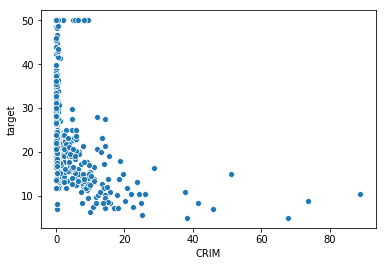

In [72]:
sns.scatterplot(x='CRIM', y='target', data=df)

## Analyze Categorical Variables

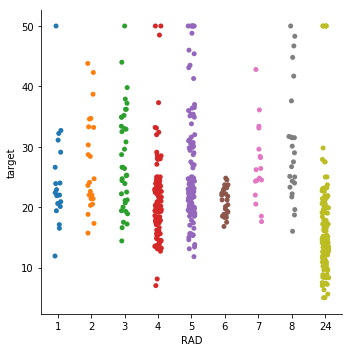

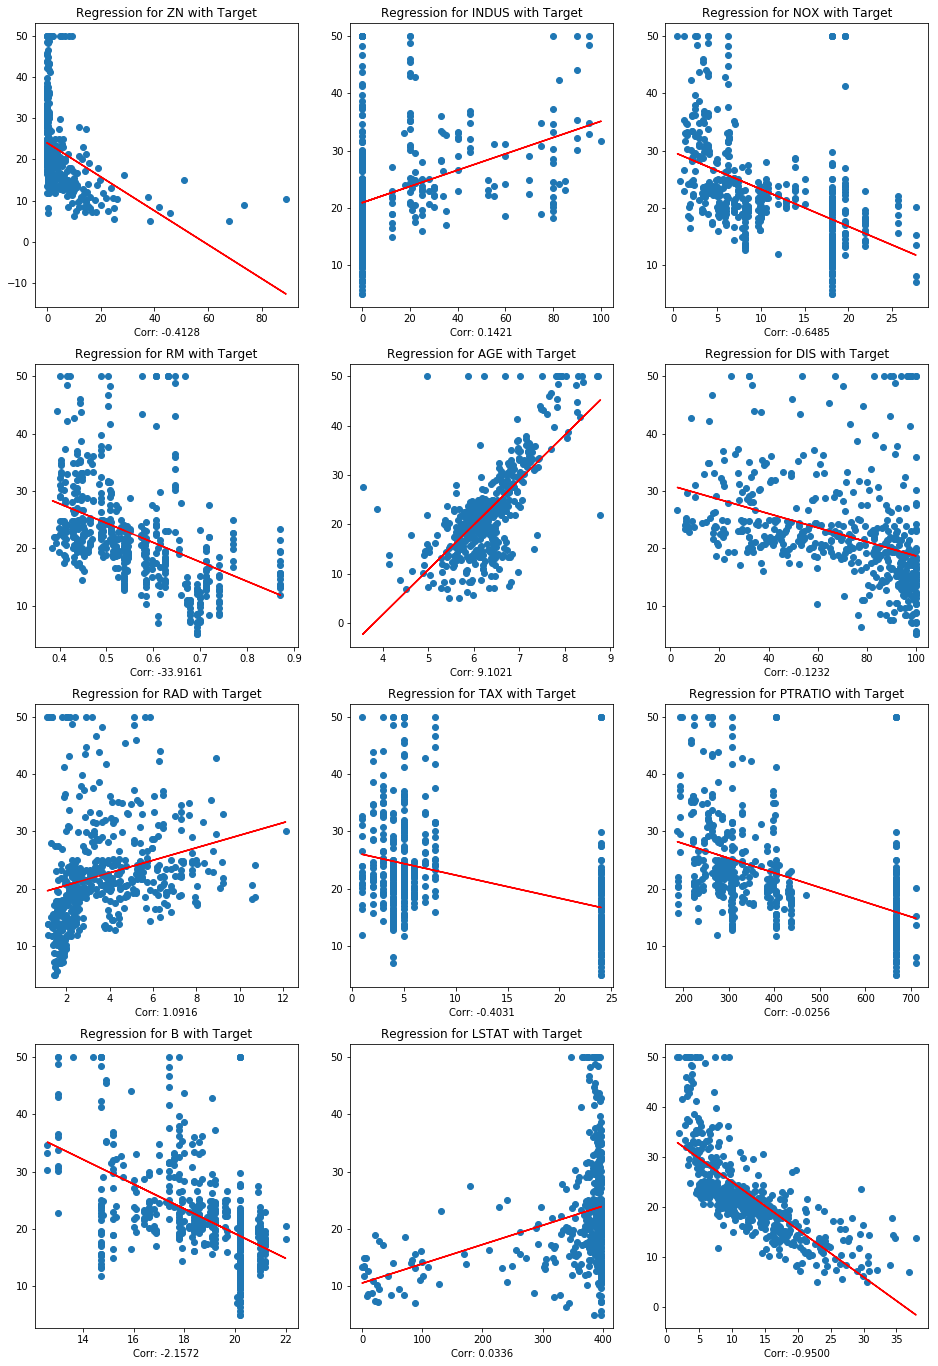

In [730]:
# Investigate the correlation patters for each feature
correlation_plot_linear(df, cols=3)

### Training a Tree Regressor on the dataset

In [154]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

tree_reg = DecisionTreeRegressor()
param_grid = {
    'max_depth': range(1,15, 3),
    'max_features': range(5, 10, 1),
    'max_leaf_nodes': range(5, 30, 1)
}

grid = GridSearchCV(tree_reg, param_grid=param_grid)

In [155]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 15, 3), 'max_features': range(5, 10), 'max_leaf_nodes': range(5, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [156]:
grid.score(X_test, y_test)

0.8406443035851796

In [152]:
_ih[-10:]

['display(train.shape, test.head(3))',
 '# This function allows to automatically optimize the binning settings for each of the columns to itertively reach ever better fits on the binning numbers\nX_train, X_test = optimize_column_binning(train, test, y_train, y_test, numeric_cols, bin_range=range(1, 30), optimize_df=True, rounds=3)',
 'def optimize_column_binning(df_train, df_test, target_train, target_test, cols, bin_range=range(1,10), one_hot_encode=False, optimize_df=False, rounds=0):\n    from sklearn.ensemble import RandomForestRegressor\n\n    # Create and attach an individual encoding\n    val_results = {}\n    for col in cols: \n        # First remove the existing encoding columns from the dataframe\n        train_sub = df_train.drop(df_train.columns[df_train.columns.str.startswith("_{}".format(col))], axis=1)\n        test_sub = df_test.drop(df_test.columns[df_test.columns.str.startswith("_{}".format(col))], axis=1)\n        \n        # Run over the range of possible bin value

# Generating the results DataFrame from the GridSearchCV log

In [735]:
results = grid.cv_results_
result_list = list(zip(results['mean_test_score'], results['mean_train_score'], results['params']))

# Generating a results Dataframe from the GridSearchCV log
scores_list = list(zip(results['mean_test_score'], results['mean_train_score']))

param_values = np.vstack([[v for k,v in result.items()] for result in results['params']])
param_labels = list(set([k for item in results['params'] for k,v in item.items()]))
param_levels = [list(set(param_values[:, idx])) for idx in range(param_values.shape[1])]

results_df = pd.DataFrame(np.concatenate([scores_list, param_values], axis=1), columns=['mean_test_score', 'mean_train_score', *param_labels])

C:\Users\frank\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


### Plotting the change of a given feature over the level of another one

This lets me understand graphically how one hyperparameter influences the changes in another one

In [736]:
param_labels

['max_features', 'max_leaf_nodes', 'max_depth']

PLOTTING 1 INTERACTION WITH TARGET


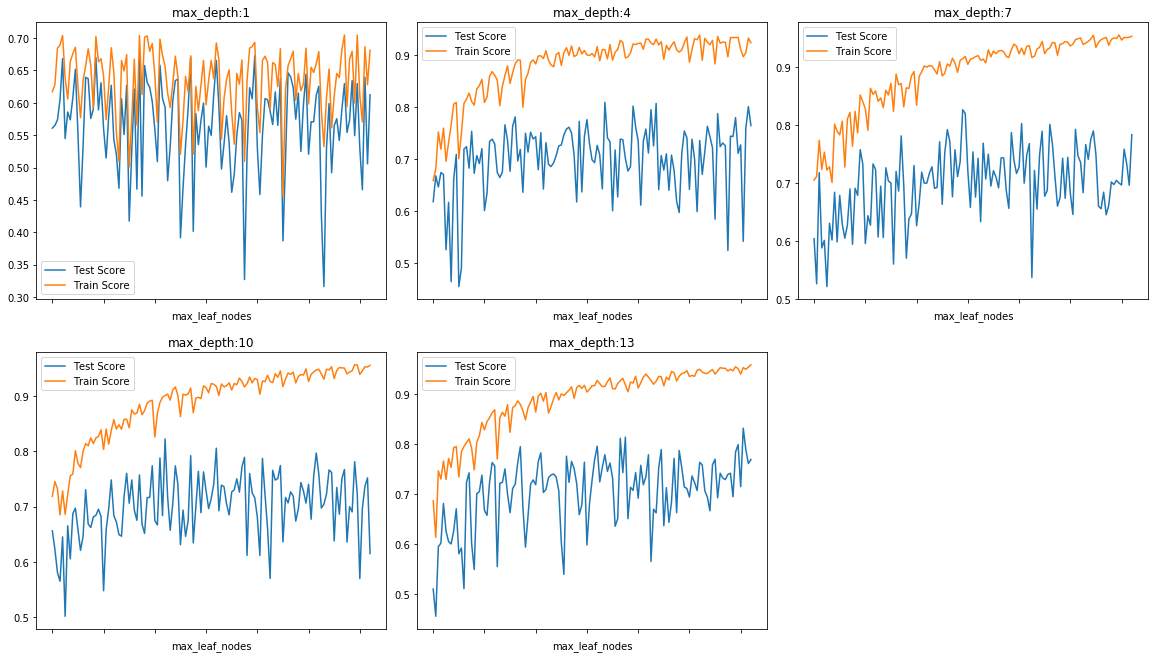

In [737]:
plot_parameter_interaction(['max_leaf_nodes', 'max_depth'])

## Supporting Functions

In [2]:
def normalize_data_input(train_df=None, test_df=None, train_target=None, test_target=None,\
                                    target_col=None, df=None, target=None):
    
    if train_df is not None and test_df is not None and train_target is not None and test_target is not None:
        X_train, X_test, y_train, y_test = train_df, test_df, train_target, test_target
    elif train_df is not None and test_df is not None and target_col is not None:
        X_train, X_test, y_train, y_test = train_df.drop(target_col, axis=1),\
                                           test_df.drop(target_col, axis=1), train_df[target_col],\
                                           test_df[target_col]
    elif df is not None and target_col is not None:
        X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'])
    elif df is not None and target is not None:
        X_train, X_test, y_train, y_test = train_test_split(fulldf, target)
    else:
        raise Exception("No valid train and test data given.")
    
    return X_train, X_test, y_train, y_test

### Data Augmentation Functions

In [3]:
def create_binned_columns(df, cols, bins=5, labels=None, one_hot_encode=False, drop=False, append=False):
    """Automatically create and append binned columns of all cols on the DF"""
    
    binned = {}
    if labels == None:
        labels = [str(ind) for ind in range(bins)]
    
    for col in cols:
        # Create the binned category
        binned[col] = pd.cut(df[col], bins, labels=labels)
    
    df_binned = pd.DataFrame(binned)
    
    if one_hot_encode:
        for col in df_binned:
            df_binned = pd.concat([df_binned, pd.get_dummies(df_binned[col], prefix='_{}_bin'.format(col), drop_first=drop)], axis=1).drop(col, axis=1)
    if append:
        df_binned = pd.concat([df, df_binned], axis=1)
    
    return df_binned

In [4]:
def append_polynomial_features(train_df=None, test_df=None, train_target=None, test_target=None,
                                    target_col=None, df=None, target=None, degree=1, interaction_only=False, inplace=False):
    # Accept input data
    X_train, X_test, y_train, y_test = normalize_data_input(train_df, test_df, train_target, test_target,\
                                                            target_col, df, target)
    
    
    # Apply polynomial transformation to the Dataset
    pol_features = PolynomialFeatures(degree=degree, interaction_only=interaction_only).fit(X_train, y_train)


    #Subset the generated features from the old ones
    train_poly = pol_features.transform(X_train)
    train_poly = train_poly[:, X_train.shape[1]:]

    test_poly = pol_features.transform(X_test)
    test_poly = test_poly[:, X_test.shape[1]:]

    # Append the newly formed Columns to the dataset
    columns = [*X_train.columns]+["poly_{}".format(i) for i in range(train_poly.shape[1])]
    print(len(columns), train_poly.shape[1])

    X_train_new = pd.DataFrame(np.hstack((X_train, train_poly)), columns=columns, index=X_train.index)
    X_test_new = pd.DataFrame(np.hstack((X_test, test_poly)), columns=columns, index=X_test.index)
    
    if inplace:
        X_train = X_train_new
        X_test = X_test_new
    else:
        return X_train_new, X_test_new

In [142]:
def add_aggregate_stats_by_distance(df, n_neighbors=None, stats=None, estimator=None, n_jobs=-1):
    """
    Given a list of columns, or a full DF the closest n_neighbors for each instance are computed.
    For each subgroup of 'kn_group' a given set of stats is computed, and joined as columns to the DataFrame.
    
    df: The DataFrame to work on
    n_neighbors: Given an int it computes a one pass, given a range of ints it runs CV over the range and
                 , validates given a RandomForest and adds the best performing number of Neighbors to the
                 DataFram
    stats: A list of stat measures to be calculated and aded for each subgroup
    estimator: Accepts a specified NearestNeighbors Model. Otherwise a standard Instance is provided for clustering
    """
    # Ensure that the number of neighbors is below thte number of training samples
    if n_neighbors >= df.shape[0]: return
    
    # Ensure that any existing prior versions of kn_grouping are dropped before starting
    if estimator is None:
        from sklearn.neighbors import NearestNeighbors
        estimator = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=n_jobs)
    
    nn = estimator.fit(df)

    indices = nn.kneighbors(return_distance=False)
    df['kn_group'] = None
    
    # First assign each group of neighbors to their kn_group
    for i in range(indices.shape[0]):
        if df.iloc[i]['kn_group'] == None:
            df.loc[df.index & indices[i, :], 'kn_group'] = i 
            df['kn_group'] = df['kn_group']
    df['kn_group'] = df['kn_group'].fillna(0)
    
    # Apply group statistics if required
    if stats is not None:
        # Create an aggregated Dataframe for the group
        grpt = df.groupby('kn_group')
        new_df = df.copy()
        
        # Calculate and append group statistics
        if 'mean' in stats:
            agg_df_mean = grpt.mean()[numeric_cols].fillna(0)
            agg_df_mean.columns = ["kn_group_{}_mean".format(key) for key in numeric_cols]
            new_df = new_df.merge(agg_df_mean.reset_index())
        # Create a median aggregation
        if 'median' in stats:
            agg_df_median = grpt.median()[numeric_cols].fillna(0)
            agg_df_median.columns = ["kn_group_{}_median".format(key) for key in numeric_cols]
            new_df = new_df.merge(agg_df_median.reset_index())
        # Create a min aggregation
        if 'min' in stats:
            agg_df_min = grpt.min()[numeric_cols].fillna(0)
            agg_df_min.columns = ["kn_group_{}_min".format(key) for key in numeric_cols]
            new_df = new_df.merge(agg_df_min.reset_index())
        # Create a max aggregation
        if 'max' in stats:
            agg_df_max = grpt.max()[numeric_cols].fillna(0)
            agg_df_max.columns = ["kn_group_{}_max".format(key) for key in numeric_cols]
            new_df = new_df.merge(agg_df_max.reset_index())
        # Create a std aggregation
        if 'std' in stats:
            agg_df_std = grpt.std()[numeric_cols].fillna(0)
            agg_df_std.columns = ["kn_group_{}_std".format(key) for key in numeric_cols]
            new_df = new_df.merge(agg_df_std.reset_index())

        # Append the new columns

        new_df['kn_group'].fillna(0).astype('category')
        df = new_df
    return df
        

### Cross Validation Helpers

In [25]:
def cross_validate_numeric_bin_size(train_df=None, test_df=None, train_target=None, test_target=None,
                                    target_col=None, df=None, target=None, model=None, bin_range=range(1,10), one_hot_encode=True, 
                                    drop=False, append=True, plot=False, estimator=None):
    """
    Convenience Wrapper around 'create_binned_columns()' to test the optimal number of global bins for all given numeric columns.
    df: The Dataframe that is to be binned
    model: Either an existing model to tune the binning parameter for, or by default a RandomForestClassifier will be used to get a quick result
    bin_range: The range of possible values of bins to try. Must be int
    one_hot_encode: Wether to generate one-hot-encodings from the bins before training the model. Only relevant when using Linear / Neural Network models
    drop: Wether the first category, and the original string encodings should be dropped from the DataFrame
    append: Wether the original dataframe should be concatenated with the new binning encoded Columns, if False the Encoding Dataframe will be returned alone
    """
    from sklearn.ensemble import RandomForestRegressor
    
    X_train, X_test, y_train, y_test = normalize_data_input(train_df, test_df, train_target, test_target, target_col, df, target)
        
    # Fit the Bins
    train_scores = []
    val_scores = []
    for i in bin_range:
        # Create binned df
        X_train_binned = create_binned_columns(X_train, numeric_cols, bins=i, labels=[str(ind) for ind in range(i)], 
                                                              one_hot_encode=one_hot_encode, drop=drop, append=append)
        X_test_binned = create_binned_columns(X_test, numeric_cols, bins=i, labels=[str(ind) for ind in range(i)], 
                                                              one_hot_encode=one_hot_encode, drop=drop, append=append)
        # Train RandomForrest Regressor
        if i % 5 == 0: print('Fitting {}th Model'.format(i))
        if estimator is None:
            estimator = RandomForestRegressor()
        estimator = estimator.fit(X_train_binned, y_train)
        train_scores.append(estimator.score(X_train_binned, y_train))
        val_scores.append(estimator.score(X_test_binned, y_test))

    # get the results
    val_max = max(val_scores)
    best_bin_num = val_scores.index(val_max)
    
    if plot:
        plt.plot(range(len(train_scores)), train_scores, '-or', label="Train Scores")
        plt.plot(range(len(train_scores)), val_scores, '-og', label="Val Scores")
        plt.legend();

    print("Done. Best validation result with {} at {} bins".format(val_max, best_bin_num))


In [41]:
def optimize_column_binning(df_train, df_test, target_train, target_test, cols, bin_range=range(1,10), one_hot_encode=False, optimize_df=False, rounds=0):    
    
    from sklearn.ensemble import RandomForestRegressor
    
    if rounds > 0:        
        for rnd in range(rounds):            
            print("Optimization Round {} of {}".format(rnd, rounds))            
            df_train, df_test = optimize_column_binning(df_train, df_test, target_train, target_test, cols, bin_range, one_hot_encode, optimize_df=True)
                                                                 
    
    # Create and attach an individual encoding    
    val_results = {}   
    for col in cols:         
        # First remove the existing encoding columns from the dataframe        
        train_sub = df_train.drop(df_train.columns[df_train.columns.str.startswith("_{}".format(col))], axis=1)
        test_sub = df_test.drop(df_test.columns[df_test.columns.str.startswith("_{}".format(col))], axis=1)
        
        # Run over the range of possible bin values and train a model to get accuracy scores
        train_scores = []
        val_scores = []
        for i in bin_range:
            # Create a binned column from the original column using i bins
            train_sub.loc[:, '{}_binned'.format(col)] = pd.cut(train_sub[col], bins=i, labels=[str(ind) for ind in range(i)], retbins=False)
            test_sub.loc[:, '{}_binned'.format(col)] = pd.cut(test_sub[col], bins=i, labels=[str(ind) for ind in range(i)], retbins=False)
            
            if one_hot_encode: 
                train_sub = pd.concat([train_sub, pd.get_dummies(train_sub["{}_binned".format(col)], prefix=\
                                                                 '_{}_bin'.format(col), drop_first=drop)], axis=1).drop('{}_binned'.format(col), axis=1)                
                test_sub = pd.concat([test_sub, pd.get_dummies(test_sub["{}_binned".format(col)],\
                                                               prefix='_{}_bin'.format(col), drop_first=drop)], axis=1)\
                                                               .drop('{}_binned'.format(col), axis=1)
            
            # Train the model            
            rf_reg = RandomForestRegressor(n_jobs=-1).fit(df_train, target_train)            
            train_scores.append(rf_reg.score(df_test, target_test))            
            val_scores.append(rf_reg.score(df_test, target_test))
            
                                                               
        # Append the best results for the current column        
        val_results[col] = {'best_score': max(val_scores), 'num_bins': val_scores.index(max(val_scores))}        
        print("Finished optimization for Column: \'{}\' :: {}".format(col, val_results[col]))
        
        # If set to iteratively optimize, then attach the optimized columns to the DataFrame and move on\n        
        if optimize_df:            
            optimal_bins = max(1, val_results[col]['num_bins'])
            df.loc[:, "{}_binned".format(col)] = pd.cut(df[col], bins=optimal_bins, labels=[str(ind) for ind in range(optimal_bins)], retbins=False)            

            if one_hot_encode:                
                df_train = pd.concat([df_train, pd.get_dummies(df_train["{}_binned".format(col)], prefix='_{}_bin'.format(col), drop_first=drop)], axis=1).drop('{}_binned'.format(col), axis=1)
                df_test = pd.concat([df_test, pd.get_dummies(df_test["{}_binned".format(col)], prefix='_{}_bin'.format(col), drop_first=drop)], axis=1).drop('{}_binned'.format(col), axis=1)
    
    # Return the optimized Dataframe\n    
    if optimize_df:        
        return df_train, df_test    

    return val_results


In [7]:
def cross_validate_polynomial_features(X_train, X_test, y_train, y_test,modelclass="", model="", rng=range(1, 5)):
    train_scrs = []
    val_scrs = []
    for i in rng:
        pol_features = PolynomialFeatures(degree=i, interaction_only=True).fit(X_train, y_train)

        X_train_poly = pol_features.transform(X_train)
        X_test_poly = pol_features.transform(X_test)

        if modelclass=='linear':
            train_scr, val_scr, _ = train_linear_model(X_train_poly, X_test_poly, y_train, y_test, return_scores=True, verbose=0)
        if modelclass=="ensemble":
            train_scr, val_scr, _ = train_ensemble_model(X_train_poly, X_test_poly, y_train, y_test, return_scores=True, verbose=0)
        # Track validation
        train_scrs.append(train_scr)
        val_scrs.append(val_scr)
    
    plot_learning_curve(train_scrs, val_scrs, ['Degree of Polynomials', 'Model Accuracy'])    
    return (train_scrs, val_scrs)

In [179]:
def cross_validate_cluster_groups(train_df=None, test_df=None, train_target=None, test_target=None, cluster_range=range(1,10, 2),
                                    target_col=None, df=None, target=None, plot=True, return_results=False):
    
    X_train, X_test, y_train, y_test = normalize_data_input(train_df, test_df, train_target, test_target,\
                                                            target_col, df, target)
    
    # This cross validates the cluster of i to the max available number of samples in both the train and test set
    train_scores = {}
    test_scores = {}
    for idx,i in enumerate(cluster_range): #range(1, min(X_train.shape[0], X_test.shape[0]), 5)

        # apply grouping with i neighbors
        train_grouped = add_aggregate_stats_by_distance(X_train, i)
        test_grouped = add_aggregate_stats_by_distance(X_test, i)

        #Test the impact on test and validation scores
        estimator = XGBRegressor().fit(train_grouped.values, y_train)
        train_scores[idx] = {'n_neighbors': i, 'score': estimator.score(train_grouped.values, y_train)}
        test_scores[idx] = {'n_neighbors': i, 'score': estimator.score(test_grouped.values, y_test)}
    
    # Display results
    max_val = max([(v['score'], v['n_neighbors']) for _,v in test_scores.items() ])
    print("Best validation result : {:.3f} with a n_neighbors: {}".format(*max_val))

    if plot:
        # plot_learning_curve(train_scores, test_scores)
        plot_learning_curve([v['score'] for _,v in train_scores.items()], [v['score'] for _,v in test_scores.items()])
        
    
    if return_results:
        return train_scores, test_scores


## Training Helpers

In [9]:
def train_ensemble_model(train_df=None, test_df=None, train_target=None, test_target=None, fulldf=None, target=None, target_col=None, 
                           model="RandomForestRegressor", 
                         param_grid=None, train_test_split=False, gridCV=False, n_jobs=-1, gridCV_depth=1, return_scores=False, verbose=1,
                         return_estimator=False):
    """
    Function enables easy training of common models just by calling the naming the model. 
    All settings can be adapted over time. GridSearch for the model is enabled by passing a param_grid and setting GridCV==True
    """
    # 1. Conduct Train test split if passed a full df
    X_train, X_test, y_train, y_test = normalize_data_input(train_df, test_df, train_target, test_target, target_col, df, target)
           
    
    # 2. IMPORT AND FIT THE MODELS
    if model == "RandomForestRegressor":
        from sklearn.ensemble import RandomForestRegressor
        estimator = RandomForestRegressor()
    if model is in ['XGBRegressor','BoostRegressor', 'xgregressor', 'XGregressor', 'XGBR']:
        from xgboost import XGBRegressor
        estimator = 
    
    # IF THE GRIDCV IS TURNED ON
    param_grid_dict = {
        'RandomForestRegressor': {
            'bootstrap': [True, False],
            'max_depth' : range(5, 10 * gridCV_depth),
            'n_estimators': range(200, 500*gridCV_depth, 10),
            'max_depth': range(5, 20*gridCV_depth),
            'max_features': ['auto', 'sqrt'][:min(1, 1*gridCV_depth)],
            'min_samples_split': range(2, 4*gridCV_depth, 2),
            'min_samples_leaf': range(1, 2*gridCV_depth),
        },
        'XGBRegressor': {
            
        },
        'XGBClassifier': {
            
        },
    }
    if gridCV or param_grid:
        if not param_grid:
            print("Using the default GridCV param_grid for the {}".format(model))
            param_grid = param_grid_dict[model]
        # Fit the GridCV
        from sklearn.model_selection import GridSearchCV
        estimator = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=n_jobs)
        
    
    # 3. Fit the model on the Testing Data
    estimator.fit(X_train, y_train)        
    
    # 4. Validate the Model
    train_scr = estimator.score(X_train, y_train)
    val_scr = estimator.score(X_test, y_test)
    if verbose > 0: print("The {} reached an {} of:\n Training {} \t Validation {}\n".format(model, 'accuracy', train_scr, val_scr))
    
    
    if return_scores:
        return (train_scr, val_scr, estimator)
    if griCV or param_grid:
        print(estimator.best_params_)
    if return_estimator:
        return estimator

In [10]:
def train_linear_model(train_df=None, test_df=None, train_target=None, test_target=None, fulldf=None, target=None, target_col=None, 
                           model="LinearRegression", 
                         param_grid=None, train_test_split=False, gridCV=False, n_jobs=-1, gridCV_depth=1, return_scores=False, verbose=1):
    """
    Function enables easy training of common models just by calling the naming the model. 
    All settings can be adapted over time. GridSearch for the model is enabled by passing a param_grid and setting GridCV==True
    """
    # 1. Conduct Train test split if passed a full df
    from sklearn.model_selection import train_test_split
    # Provides a full df and a column for target feature
    if fulldf is not None  and target_col is not None:
        X_train, X_test, y_train, y_test = train_test_split(fulldf.drop(target_col), fulldf[target_col])
    if fulldf is not None and target is not None:
        X_train, X_test, y_train, y_test = train_test_split(fulldf, target)
    # -- Otherwise pass the given train and test sets to a unified structure
    
    # Provides a list of train and test dfs including the respective target column
    if train_df is not None and test_df is not None and target_col is not None:
        X_train, y_train = train_df, train_df[target_col]
        X_test, y_test = test_df, test_df[target_col]
    if train_df is not None and train_target is not None and test_df is not None and test_target is not None:
        X_train, y_train, X_test, y_test = train_df, train_target, test_df, test_target
    
    # Normalize the Dataset
    
    
    # 2. IMPORT AND FIT THE MODELS
    if model in ["LinearRegression","OrdinaryLeastSquares","OLS"]:
        from sklearn.linear_model import LinearRegression
        estimator = LinearRegression()
    if model in ["RidgeRegression", "Ridge"]:
        from sklearn.linear_model import Ridge
        estimator = Ridge()
    if model == "Lasso":
        from sklearn.linear_model import Lasso
        estimator = Lasso()
    if model == "LassoCV":
        from sklearn.linear_model import LassoCV
        estimator = LassoCV()
    if model == "LassoLarsIC":
        from sklearn.linear_model import LassoLarsIC
        estimator = LassoLarsIC()
    if model == "ElasticNet":
        from sklearn.linear_model import ElasticNet
        estimator = ElasticNet()
    
    
    
    # IF THE GRIDCV IS TURNED ON
    param_grid_dict = {
        'LinearRegression': {
    
        },
        'RidgeRegression': {
            
        },
        'Lasso': {
            
        },
        'ElasticNet': {
#             'alpha': range(0.3, 1.0, .1*gridCV_depth) if gridCV_depth > 2.0 else 1.0,
#             'l1_ratio': range(0.1, 1.0, 0.3),
            
        }
    }
    if gridCV:
        if not param_grid:
            print("Using the default GridCV param_grid for the {}".format(model))
            param_grid = param_grid_dict[model]
        # Fit the GridCV
        from sklearn.model_selection import GridSearchCV
        estimator = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=n_jobs)
        
    
    # 3. Fit the model on the Testing Data
    estimator.fit(X_train, y_train)
    
    # 4. Validate the Model
    train_scr = estimator.score(X_train, y_train)
    val_scr = estimator.score(X_test, y_test)
    if verbose>0: print("The {} reached an {} of:\n Training {} \t Validation {}\n".format(model, 'accuracy', train_scr, val_scr))
    
    if return_scores:
        return (train_scr, val_scr, estimator)
    
    return estimator

### Display Helpers

In [11]:
def plot_learning_curve(train_scores, val_scores, labels=None, title=None, colors=[]):
    ctrain, ctest = colors if len(colors) else ('r', 'g')
    title = title if title else "Learning Curve"
    plt.plot(range(len(train_scores)), train_scores, '-o{}'.format(ctrain), label="Train Scores")
    plt.plot(range(len(val_scores)), val_scores, '-o{}'.format(ctest), label="Test Scores")
    if labels:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    plt.title(title)
    plt.legend()

In [12]:
def plot_complexity_curve(grid, ncols=3):
    
    
    # Extract information from GridSearchCV Dict
    results = grid.cv_results_
    tuned_params = set([key for item in  results['params'] for key,_ in item.items()])

    # Set plotting parameters
    nrows = max(1, len(tuned_params) // ncols)
    ncols = 1 if len(tuned_params) == 1 else ncols
    plt.subplots(figsize=(16, nrows * 5))
    
    print(nrows, ncols)
    for idx, parameter in enumerate(tuned_params):
    
        params = list(set([param[parameter] for param in results['params']]))
        print(params)
        mean_train_score = list(set(results['mean_train_score']))
        mean_test_score = list(set(results['mean_test_score']))

        plt.subplot(nrows, ncols, idx+1)
        
        plt.plot(params, mean_train_score, '-or', label="Mean Training Score")
        plt.plot(params, mean_test_score, '-og', label="Mean Test Score")
        plt.title("Complexity Curve for {}".format(parameter))
        plt.xlabel("Max Depth Settings")
        plt.ylabel("Score")

In [13]:
# Group the dataset to focus on changes of test and train scores in respect to changes in a given parameter
def plot_parameter_interaction(params):
    par_idx = [param_labels.index(param) for param in params]
    subset_param_levels = [[min(lvl)] if idx not in par_idx else lvl for idx, lvl in enumerate(param_levels)]

    labels = [label for label in param_labels if label not in params] + params[1:] + [params[0]]
    # plot a complete set of all combinations of levels
    a = results_df.groupby(labels).agg('mean')

    # display(params, param_labels, par_idx, subset_param_levels)
    n_plots = np.product([len(param_levels[param_labels.index(par)]) for par in params])

    ncols = 3
    nrows = n_plots / ncols + 2

    plt.close('all')
    plt.subplots(figsize=(16, nrows * 4.5))

    if len(params) == 2:
        print("PLOTTING 1 INTERACTION WITH TARGET")
        # 1. Iterate over a combination of 1 feature level with the target
        idx = 1
        # Generate the index
        for idx1 in param_levels[param_labels.index(labels[0])]:
                plt.subplot(nrows, ncols, idx)
                df = a.loc[idx1]
                df['mean_test_score'].plot(label="Test Score")
                df['mean_train_score'].plot(label="Train Score")
                plt.title("{}:{}".format(params[1], idx1 ))
                plt.xlabel(params[0])
                plt.legend()

                idx += 1
    
    # TODO: As the complexity of the search space is too high, implement a way to subset the most relevant interations from
    # the GridSearch CV Results
    elif len(params) == 3:
        print("PLOTTING 2 INTERACTION WITH TARGET")

        # 2. Iterate over a combination of 2 feature levels with the target
        idx = 1
        for idx1 in param_levels[param_labels.index(labels[0])]:
            for idx2 in param_levels[param_labels.index(labels[1])]:
                plt.subplot(nrows, ncols, idx)
                df = a.loc[idx1, idx2]
                df['mean_test_score'].plot(label="Test Score")
                df['mean_train_score'].plot(label="Train Score")
                plt.title("{}:{}\n{}L=:{}".format(labels[1], idx1, labels[2], idx2))
                
                plt.legend()
                idx += 1

              
    elif len(params) == 4:
        print("PLOTTING 3 INTERACTION WITH TARGET")

        # 3. Iterate over a combination of 3 hyperparamets with the target
        idx = 1
        for idx1 in param_levels[param_labels.index(labels[0])]:
            for idx2 in param_levels[param_labels.index(labels[1])]:
                for idx3 in param_levels[2]:
                    plt.subplot(nrows, ncols, idx)
                    df = a.loc[idx_lvl1, idx_lvl2, idx_lvl3]
                    df['mean_test_score'].plot(label="Test Score")
                    df['mean_train_score'].plot(label="Train Score")
                    plt.title("{}:{}\n{}L=:{} & {}:{}".format(labels[0], idx_lvl1, labels[1], idx_lvl2, labels[2], idx_lvl3))
                    plt.legend()

                    idx += 1


    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.5)
    

In [14]:
def correlation_plot_linear(df, model='linear',height_factor=1, cols=2,  target_label="Target"):
    """This function plots a series of linear interactions between all feature columns in the dataframe"""
    from sklearn.linear_model import LinearRegression
    plt.subplots(figsize=(10+2*cols, len(df.columns) // (cols) * (5 + height_factor)))

    idx = 0
    for col in df.columns:
        n_rows = len(df.columns) / cols
        if str(df[col].dtype) not in ['category', 'str']:
            idx += 1
            single_data = df[col].values.reshape(-1, 1)

            clf = LinearRegression().fit(single_data, target)
            preds = clf.predict(single_data)

            plt.title("Regression for {} with {}".format(col, target_label))
            plt.subplot(n_rows, cols,  idx);
            plt.scatter(single_data, target);
            plt.plot(single_data, preds, 'r-');
            plt.xlabel("Corr: {:.4f}".format(clf.coef_[0]))

In [15]:
def plot_feature_weights(train_df=None, test_df=None, train_target=None, test_target=None, fulldf=None, target=None, target_col=None, estimator=None):
    X_train, X_test, y_train, y_test = normalize_data_input(train_df, test_df, train_target, test_target, fulldf, target, target_col)
    if estimator is None:
        from sklearn.tree import DecisionTreeRegressor
        estimator = DecisionTreeRegressor()
    estimator = estimator.fit(X_train, y_train)
    feature_weights = pd.DataFrame(estimator.feature_importances_, feature_names, columns=['feature_weight']).sort_values('feature_weight', ascending=False)
    feature_weights.plot(kind='bar')
    plt.title("Feature Weights");

In [16]:
#TODO: Find out how to display multiple plot calls on a single "Meta-Call" to display them all at once
def plot_all_parameter_interactions(params):
    # Generate the cartesian product of the given list of labels
    import itertools
    plots = []
    for element in [element for element in set(itertools.product(params, params)) if element[0] != element[1]]:
        plot_parameter_interaction([*element])


In [17]:
def correlation_plot_linear(df, model='linear',height_factor=1, cols=2,  target_label="Target"):
    """This function plots a series of linear interactions between all feature columns in the dataframe"""
    from sklearn.linear_model import LinearRegression
    plt.subplots(figsize=(10+2*cols, len(df.columns) // (cols) * (5 + height_factor)))

    idx = 0
    for col in df.columns:
        n_rows = len(df.columns) / cols
        if str(df[col].dtype) not in ['category', 'str']:
            idx += 1
            single_data = df[col].values.reshape(-1, 1)

            clf = LinearRegression().fit(single_data, target)
            preds = clf.predict(single_data)

            plt.title("Regression for {} with {}".format(col, target_label))
            plt.subplot(n_rows, cols,  idx);
            plt.scatter(single_data, target);
            plt.plot(single_data, preds, 'r-');
            plt.xlabel("Corr: {:.4f}".format(clf.coef_[0]))